In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel
import networkx as nx

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_mediation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

In [3]:
howell_data = pd.read_csv("../data/Howell1.csv", sep=';')
howell_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
howell_data.tail()

,height,weight,age,male
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1
543,158.750,52.531624,68.0,1


In [5]:
howell_data.shape

(544, 4)

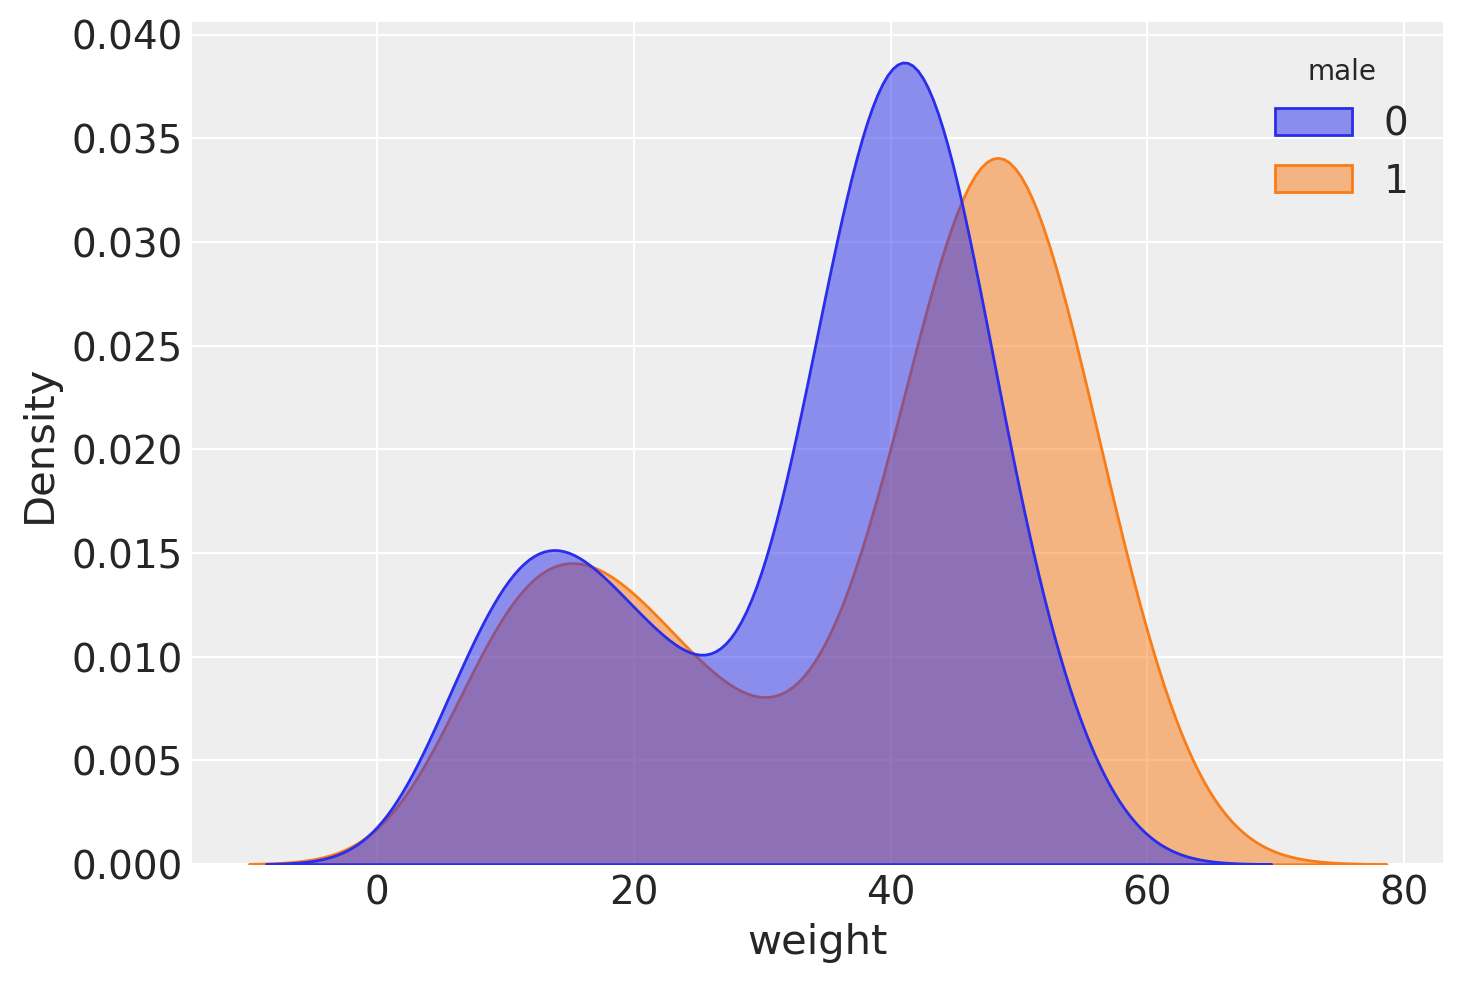

In [6]:
_ = sns.kdeplot(data=howell_data, x='weight', hue='male', fill=True, common_norm=False, alpha=0.5)

/opt/anaconda3/envs/cmdstan_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


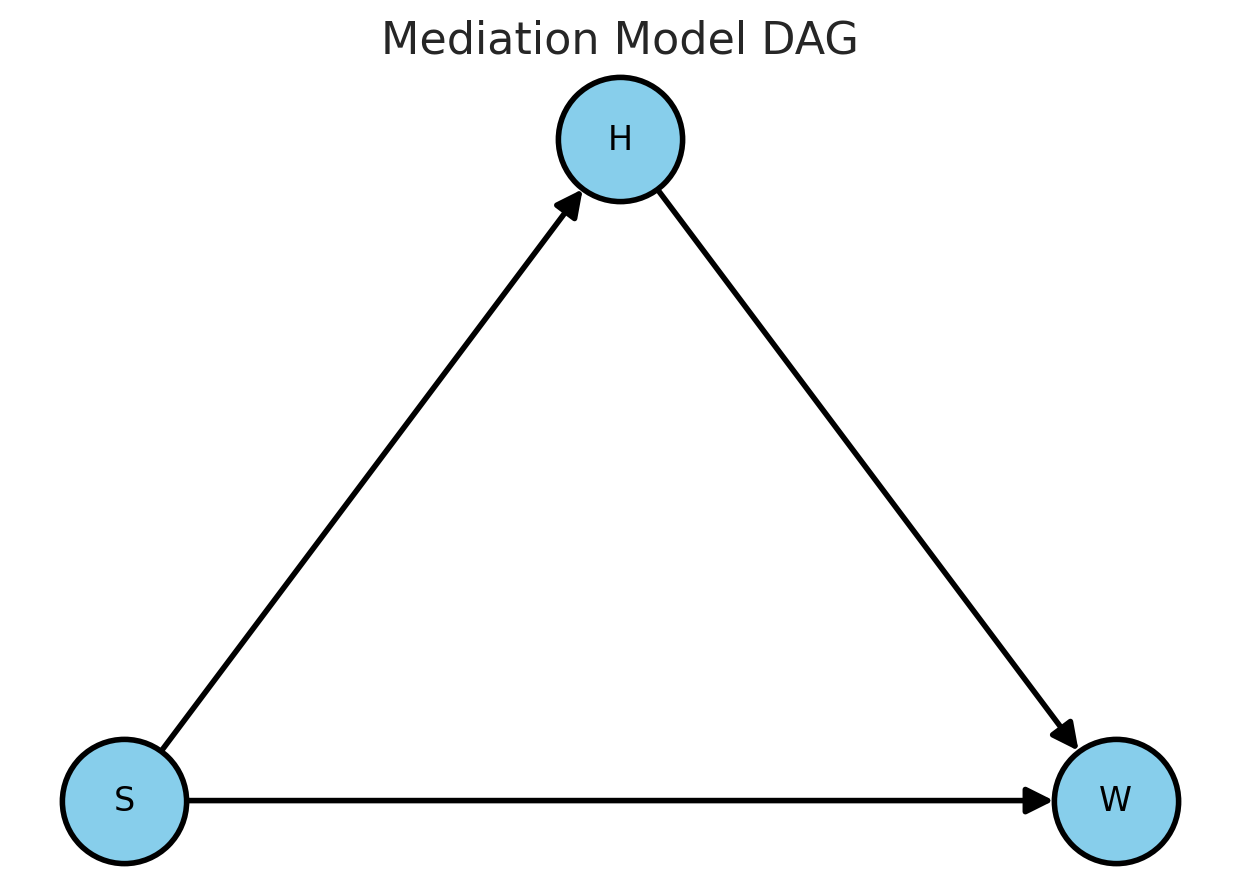

In [7]:
# Creazione del Directed Acyclic Graph (DAG) per il modello di mediazione
G = nx.DiGraph()

# Aggiunta dei nodi
G.add_nodes_from(["S", "W", "H"])

# Aggiunta degli archi che rappresentano le relazioni causali
G.add_edges_from([("S", "W"), ("S", "H"), ("H", "W")])

# Posizionamento dei nodi usando il layout 'planar'
pos = nx.planar_layout(G)

# Impostazioni per i nodi più grandi e le dimensioni globali più piccole
options = {
    "font_size": 12,
    "node_size": 2000,
    "node_color": "skyblue",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

plt.figure(figsize=(6, 4))  # Dimensioni globali più piccole
nx.draw(G, pos, **options, with_labels=True, arrowsize=20)

plt.title("Mediation Model DAG")
plt.show()

In [8]:
stan_file = os.path.join('stan', 'mediation_model.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N; // Number of observations
  array[N] int S; // Sex indicator (0 for F, 1 for M), Predictor
  array[N] real H; // Height, Mediator
  array[N] real W; // Weight, Outcome
}

parameters {
  real alphaH; // Intercept for height model
  real betaH; // Effect of sex on height
  real alphaW; // Intercept for weight model
  real betaW_H; // Effect of height on weight
  real betaW_S; // Direct effect of sex on weight
  real<lower=0> sigmaH; // Std dev for height model
  real<lower=0> sigmaW; // Std dev for weight model
}

model {
  // Priors
  alphaH ~ normal(0, 1); // Less restrictive priors for intercepts and effects
  betaH ~ normal(0, 1);
  alphaW ~ normal(0, 1);
  betaW_H ~ normal(0, 1);
  betaW_S ~ normal(0, 1);
  sigmaH ~ cauchy(0, 1); // Using a Cauchy distribution for sigma, more appropriate for std devs
  sigmaW ~ cauchy(0, 1);
  
  // Mediation Model
  for (i in 1:N) {
    // A path: Effect of sex on height
    H[i] ~ normal(alphaH + betaH * S[i], sigmaH);
   

In [9]:
howell_data['H_standardized'] = (howell_data['height'] - howell_data['height'].mean()) / howell_data['height'].std()
howell_data['W_standardized'] = (howell_data['weight'] - howell_data['weight'].mean()) / howell_data['weight'].std()

stan_data = {
    "N": howell_data.shape[0],
    "S": howell_data["male"].to_numpy(),  # Ensuring this is an array if not already
    "H": howell_data["H_standardized"].to_numpy(),  # Use the standardized height
    "W": howell_data["W_standardized"].to_numpy()   # Use the standardized weight
}

In [10]:
model = CmdStanModel(stan_file=stan_file)
print(model)

CmdStanModel: name=mediation_model
	 stan_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/mediation_model.stan
	 exe_file=/Users/corradocaudek/_repositories/temp/chapter_5/stan/mediation_model
	 compiler_options=stanc_options={}, cpp_options={}


In [11]:
fit = model.sample(data=stan_data, adapt_delta = 0.95)

09:50:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:50:03 - cmdstanpy - INFO - CmdStan done processing.


09:50:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'mediation_model.stan', line 31, column 4 to column 49)
Consider re-running with show_console=True if the above output is unclear!


In [12]:
print(fit.diagnose())

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp7sh9o0br/mediation_model72idcldn/mediation_model-20240616095002_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp7sh9o0br/mediation_model72idcldn/mediation_model-20240616095002_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp7sh9o0br/mediation_model72idcldn/mediation_model-20240616095002_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmp7sh9o0br/mediation_model72idcldn/mediation_model-20240616095002_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



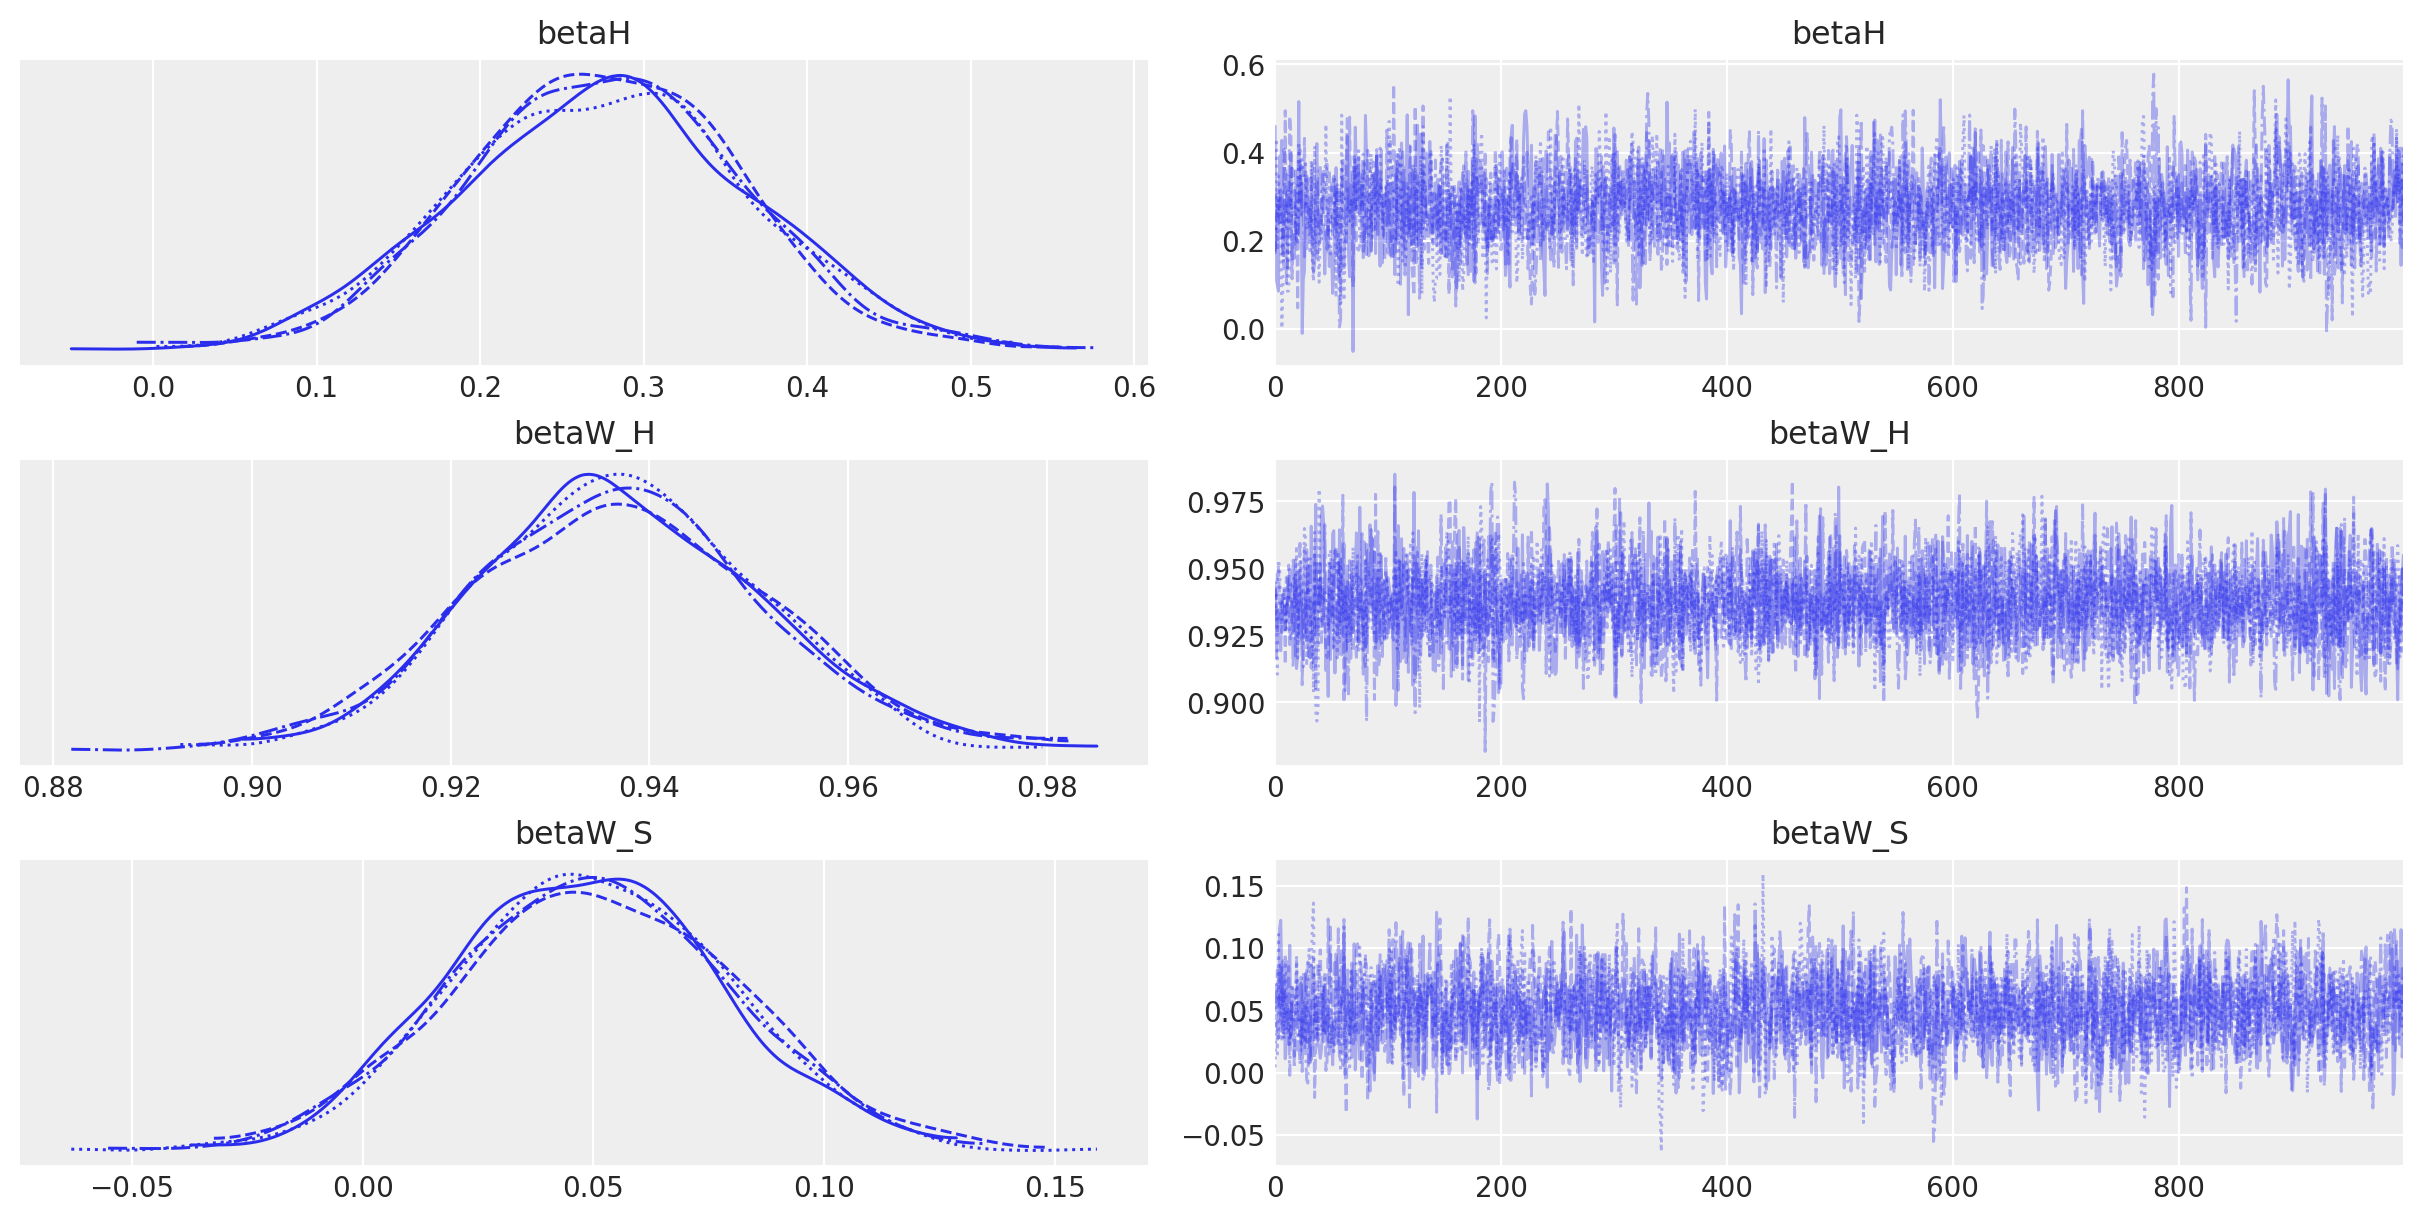

In [13]:
_ = az.plot_trace(fit, var_names=(["betaH", "betaW_H", "betaW_S"]))

In [14]:
az.summary(fit, var_names=(["betaH", "betaW_H", "betaW_S"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betaH,0.28,0.09,0.10,0.45,0.0,0.0,2747.03,2638.42,1.0
betaW_H,0.94,0.01,0.91,0.96,0.0,0.0,4396.21,2429.79,1.0
betaW_S,0.05,0.03,-0.01,0.11,0.0,0.0,2638.28,3069.02,1.0


In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

cmdstanpy: 1.2.3

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

scipy     : 1.13.1
numpy     : 1.26.4
matplotlib: 3.8.4
arviz     : 0.18.0
seaborn   : 0.13.2
pandas    : 2.2.2
networkx  : 3.3

Watermark: 2.4.3

